## Model Analysis of Heart Disease

### Prepration of Dataset

In [ ]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LinearRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report

In [ ]:
import numpy as np

In [42]:
import eli5
from eli5.sklearn import PermutationImportance

In [41]:
import shap

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [44]:
heart = pd.read_csv('heartdata.csv')

In [46]:
heart = heart.rename(columns={"cp": "chest_pain", "trestbps": "blood_pressure", "fbs": "blood_sugar", "ca": "vessels", "chol": "cholesterol"})

**Scale features** (scale their value in a range)

In [47]:
standardScaler = StandardScaler()
columns_to_scale = ['age', 'blood_pressure', 'cholesterol', 'thalach', 'oldpeak']
heart[columns_to_scale] = standardScaler.fit_transform(heart[columns_to_scale])

**One-hot encode categorical features**

In [48]:
heart = pd.get_dummies(heart, columns = ['sex', 'chest_pain', 'blood_sugar', 'restecg', 'exang', 'slope', 'thal'], drop_first=True)

**Separate features from target labels (healthy or sick)**

In [49]:
labels = heart['target']
features = heart.drop(['target'], axis = 1)

**Training & Testing by Splitting the Dataset**

In [50]:
features_train , features_test, labels_train, labels_test = train_test_split(features, labels, test_size= 0.2, random_state=42)

### Random Forest

**Find the optimal number of decision trees for the Random Forest model (from a list of options)** 

[0.7704918032786885, 0.8688524590163934, 0.8688524590163934, 0.8524590163934426, 0.8688524590163934, 0.8524590163934426, 0.8524590163934426, 0.8524590163934426]


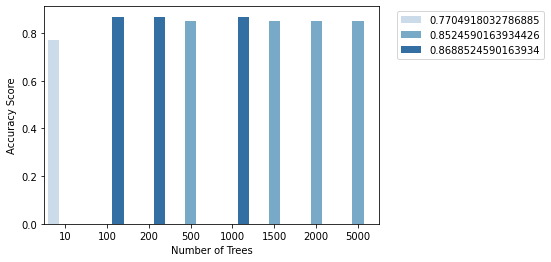

In [51]:
randomForest_scores = []
trees = [10, 100, 200, 500, 1000, 1500, 2000, 5000]
for x in trees:
    randomForest = RandomForestClassifier(n_estimators = x, random_state = 1, max_depth=1)
    randomForest.fit(features_train, labels_train)
    randomForest_scores.append(randomForest.score(features_test, labels_test))
print(randomForest_scores)

sns.barplot(trees, randomForest_scores, hue=randomForest_scores, palette='Blues')
plt.xlabel('Number of Trees')
plt.ylabel('Accuracy Score')
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")

**Find the optimal max_depth for the Random Forest model (from a list of options)** 

[0.8688524590163934, 0.8524590163934426, 0.8360655737704918, 0.8360655737704918]


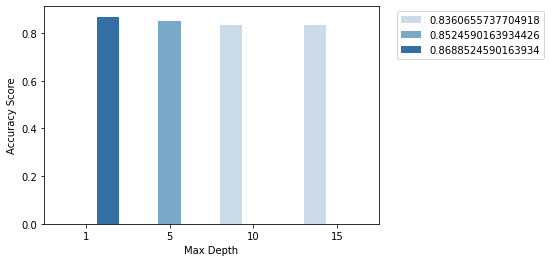

In [ ]:
randomForest_scores = []
depth = [1, 5, 10, 15]
for x in depth:
    randomForest = RandomForestClassifier(n_estimators = 1000, random_state = 42, max_depth= x)
    randomForest.fit(features_train, labels_train)
    randomForest_scores.append(randomForest.score(features_test, labels_test))
print(randomForest_scores)

sns.barplot(depth, randomForest_scores, hue=randomForest_scores, palette='Blues')
plt.xlabel('Max Depth')
plt.ylabel('Accuracy Score')
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")

**Instantiate model with 1000 decision trees and max depth of 1 (optimal numbers based on iterated experiments above)**

In [ ]:
randomForest = RandomForestClassifier(n_estimators = 1000, random_state = 1, max_depth=1)

**Train the model on features and labels training data**

In [ ]:
randomForest.fit(features_train, labels_train);

**Test the model on features and labels test data to assess its accuracy**

In [ ]:
randomForest.score(features_test, labels_test)

score = round(randomForest.score(features_test,labels_test), 3) *100

print(f"Random Forest accuracy is {score}%")

labels_predicted = randomForest.predict(features_test)
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
print("Classification Report is:\n",classification_report(labels_test,labels_predicted))
arr = confusion_matrix(labels_test,labels_predicted)
TP = arr[1][1]
TN = arr[0][0]
FP = arr[0][1]
FN = arr[1][0]
print("Confusion Matrix:\n",confusion_matrix(labels_test, labels_predicted))
print("Training Score:\n",randomForest.score(features_train,labels_train)*100)
print("Mean Squared Error:\n",mean_squared_error(labels_test,labels_predicted))
print("R2 score is:\n",r2_score(labels_test,labels_predicted))

Random Forest accuracy is 86.9%
Classification Report is:
               precision    recall  f1-score   support

           0       0.84      0.90      0.87        29
           1       0.90      0.84      0.87        32

    accuracy                           0.87        61
   macro avg       0.87      0.87      0.87        61
weighted avg       0.87      0.87      0.87        61

Confusion Matrix:
 [[26  3]
 [ 5 27]]
Training Score:
 81.81818181818183
Mean Squared Error:
 0.13114754098360656
R2 score is:
 0.47413793103448276


In [53]:
print('True Positives:', TP)
print('True Negatives:', TN)
print('False Positives:', FP)
print('False Negatives:', FN)
confaccuracy = (float (TP+TN) / float(TP + TN + FP + FN))
confmisclassification = 1- confaccuracy
confsensitivity = (TP / float(TP + FN))
confprecision = (TN / float(TN + FP))
conff1 = 2 * ((confprecision * confsensitivity) / (confprecision + confsensitivity))
print('-'*50)
print(f'Accuracy: {round(confaccuracy,2)}') 
print(f'Mis-Classification: {round(confmisclassification,2)}') 
print(f'Sensitivity: {round(confsensitivity,2)}') 
print(f'Precision: {round(confprecision,2)}')
print(f'f_1 Score: {round(conff1,2)}')

True Positives: 27
True Negatives: 26
False Positives: 3
False Negatives: 5
--------------------------------------------------
Accuracy: 0.87
Mis-Classification: 0.13
Sensitivity: 0.84
Precision: 0.9
f_1 Score: 0.87


**Feature ranking**

In [54]:
perm = PermutationImportance(randomForest, random_state=42).fit(features_test, labels_test)
eli5.show_weights(perm, feature_names = features_test.columns.tolist())

Weight,Feature
0.0197 ± 0.0435,vessels
0.0131 ± 0.0131,blood_pressure
0.0131 ± 0.0131,cholesterol
0.0098 ± 0.0393,thal_3
0.0066 ± 0.0262,thalach
0.0033 ± 0.0131,chest_pain_1
0 ± 0.0000,blood_sugar_1
0 ± 0.0000,chest_pain_3
0 ± 0.0000,restecg_1
0 ± 0.0000,restecg_2


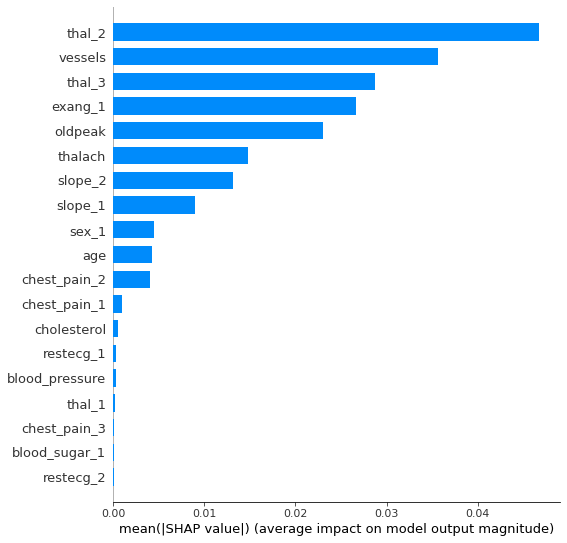

In [55]:
explainer = shap.TreeExplainer(randomForest)
shap_values = explainer.shap_values(features_test)

shap.summary_plot(shap_values[1], features_test, plot_type="bar")

**Confusion matrix**

Text(0.5, 1.0, 'Random Forest: Confusion Matrix')

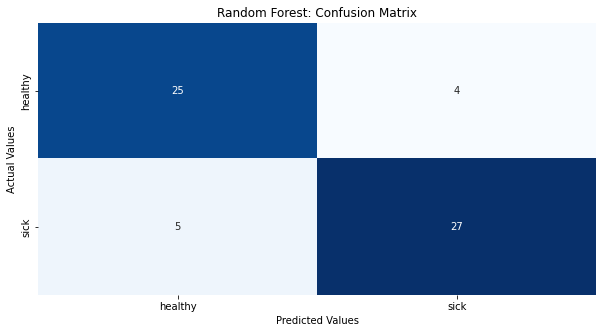

In [56]:
labels_predicted = randomForest.predict(features_test)
plt.subplots(figsize=(10,5))

conf_mat = confusion_matrix(labels_test, labels_predicted)
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=['healthy', 'sick'], yticklabels=['healthy', 'sick'])
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.title('Random Forest: Confusion Matrix')

### K Nearest Neighbors

In [65]:
knn = KNeighborsClassifier(n_neighbors = 11)
knn.fit(features_train, labels_train)
prediction = knn.predict(features_test)


score = round(knn.score(features_test, labels_test), 3) *100
print(f"K Nearest Neighbors accuracy is {score}%")

labels_predicted = knn.predict(features_test)
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
print("Classification Report is:\n",classification_report(labels_test,labels_predicted))
arr = confusion_matrix(labels_test,labels_predicted)
TP = arr[1][1]
TN = arr[0][0]
FP = arr[0][1]
FN = arr[1][0]
print("Confusion Matrix:\n",confusion_matrix(labels_test, labels_predicted))
print("Training Score:\n",knn.score(features_train,labels_train)*100)
print("Mean Squared Error:\n",mean_squared_error(labels_test,labels_predicted))
print("R2 score is:\n",r2_score(labels_test,labels_predicted))

K Nearest Neighbors accuracy is 82.0%
Classification Report is:
               precision    recall  f1-score   support

           0       0.80      0.83      0.81        29
           1       0.84      0.81      0.83        32

    accuracy                           0.82        61
   macro avg       0.82      0.82      0.82        61
weighted avg       0.82      0.82      0.82        61

Confusion Matrix:
 [[24  5]
 [ 6 26]]
Training Score:
 83.05785123966942
Mean Squared Error:
 0.18032786885245902
R2 score is:
 0.2769396551724138


In [67]:
print('True Positives:', TP)
print('True Negatives:', TN)
print('False Positives:', FP)
print('False Negatives:', FN)
confaccuracy = (float (TP+TN) / float(TP + TN + FP + FN))
confmisclassification = 1- confaccuracy
confsensitivity = (TP / float(TP + FN))
confprecision = (TN / float(TN + FP))
conff1 = 2 * ((confprecision * confsensitivity) / (confprecision + confsensitivity))
print('-'*50)
print(f'Accuracy: {round(confaccuracy,2)}') 
print(f'Mis-Classification: {round(confmisclassification,2)}') 
print(f'Sensitivity: {round(confsensitivity,2)}') 
print(f'Precision: {round(confprecision,2)}')
print(f'f_1 Score: {round(conff1,2)}')

True Positives: 26
True Negatives: 24
False Positives: 5
False Negatives: 6
--------------------------------------------------
Accuracy: 0.82
Mis-Classification: 0.18
Sensitivity: 0.81
Precision: 0.83
f_1 Score: 0.82


**Find the optimal k value (from 1-20)**

Max K Nearest Neighbors Accuracy is 90.16%
Best K is 23


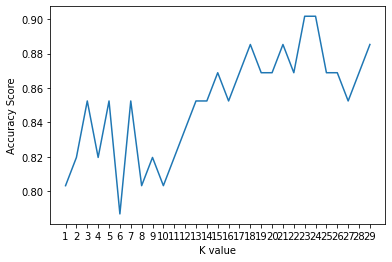

In [ ]:
accuracyScores = []

for x in range(1,30):
    knn2 = KNeighborsClassifier(n_neighbors = x)
    knn2.fit(features_train, labels_train)
    accuracyScores.append(knn2.score(features_test, labels_test))
    
    
sns.lineplot(range(1,30), accuracyScores)
plt.xticks(np.arange(1,30,1))
plt.xlabel("K value")
plt.ylabel("Accuracy Score")


best_k = accuracyScores.index(max(accuracyScores)) + 1
max_score = round((max(accuracyScores) * 100), 2) 

print(f"Max K Nearest Neighbors Accuracy is {max_score}%")
print(f"Best K is {best_k}")

In [ ]:
knn = KNeighborsClassifier(n_neighbors = 23)
knn.fit(features_train, labels_train)
prediction = knn.predict(features_test)


score = round(knn.score(features_test, labels_test), 3) *100
print(f"K Nearest Neighbors accuracy is {score}%")

K Nearest Neighbors accuracy is 90.2%


In [ ]:
perm = PermutationImportance(knn, random_state=1).fit(features_test, labels_test)
eli5.show_weights(perm, feature_names = features_test.columns.tolist())

Weight,Feature
0.0852 ± 0.0700,vessels
0.0623 ± 0.0564,thalach
0.0361 ± 0.0321,thal_2
0.0295 ± 0.0131,slope_1
0.0295 ± 0.0321,exang_1
0.0262 ± 0.0491,blood_pressure
0.0230 ± 0.0161,chest_pain_3
0.0230 ± 0.0262,chest_pain_2
0.0197 ± 0.0321,thal_3
0.0197 ± 0.0245,slope_2


Text(0.5, 1.0, 'K Nearest Neighbors: Confusion Matrix')

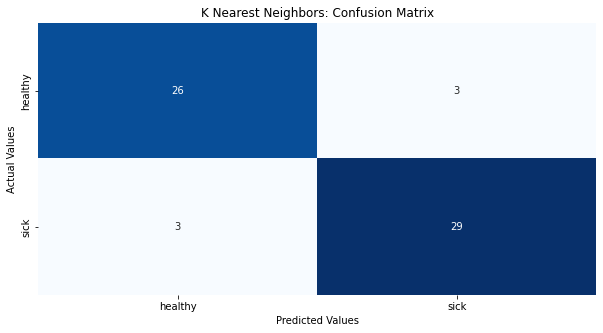

In [ ]:
labels_predicted = knn.predict(features_test)
plt.subplots(figsize=(10,5))

conf_mat = confusion_matrix(labels_test, labels_predicted)
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=['healthy', 'sick'], yticklabels=['healthy', 'sick'])
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.title('K Nearest Neighbors: Confusion Matrix')

In [ ]:
print(classification_report(labels_test, labels_predicted, target_names = ['healthy', 'sick']))

              precision    recall  f1-score   support

     healthy       0.90      0.90      0.90        29
        sick       0.91      0.91      0.91        32

    accuracy                           0.90        61
   macro avg       0.90      0.90      0.90        61
weighted avg       0.90      0.90      0.90        61



### Logistic Regression

In [68]:
logisticRegression = LogisticRegression( solver='lbfgs')
logisticRegression.fit(features_train,labels_train)
logisticRegression.score(features_test,labels_test)
score = round(logisticRegression.score(features_test,labels_test), 3) *100
print(f"Logistic Regression accuracy is {score}%")

y_pred=logisticRegression.predict(features_test)
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
print("Classification Report is:\n",classification_report(labels_test,y_pred))
arr = confusion_matrix(labels_test,y_pred)
TP = arr[1][1]
TN = arr[0][0]
FP = arr[0][1]
FN = arr[1][0]
print("Confusion Matrix:\n",confusion_matrix(labels_test,y_pred))
print("Training Score:\n",logisticRegression.score(features_train,labels_train)*100)
print("Mean Squared Error:\n",mean_squared_error(labels_test,y_pred))
print("R2 score is:\n",r2_score(labels_test,y_pred))

Logistic Regression accuracy is 90.2%
Classification Report is:
               precision    recall  f1-score   support

           0       0.87      0.93      0.90        29
           1       0.93      0.88      0.90        32

    accuracy                           0.90        61
   macro avg       0.90      0.90      0.90        61
weighted avg       0.90      0.90      0.90        61

Confusion Matrix:
 [[27  2]
 [ 4 28]]
Training Score:
 85.12396694214877
Mean Squared Error:
 0.09836065573770492
R2 score is:
 0.6056034482758621


In [69]:
print('True Positives:', TP)
print('True Negatives:', TN)
print('False Positives:', FP)
print('False Negatives:', FN)
confaccuracy = (float (TP+TN) / float(TP + TN + FP + FN))
confmisclassification = 1- confaccuracy
confsensitivity = (TP / float(TP + FN))
confprecision = (TN / float(TN + FP))
conff1 = 2 * ((confprecision * confsensitivity) / (confprecision + confsensitivity))
print('-'*50)
print(f'Accuracy: {round(confaccuracy,2)}') 
print(f'Mis-Classification: {round(confmisclassification,2)}') 
print(f'Sensitivity: {round(confsensitivity,2)}') 
print(f'Precision: {round(confprecision,2)}')
print(f'f_1 Score: {round(conff1,2)}')

True Positives: 28
True Negatives: 27
False Positives: 2
False Negatives: 4
--------------------------------------------------
Accuracy: 0.9
Mis-Classification: 0.1
Sensitivity: 0.88
Precision: 0.93
f_1 Score: 0.9


In [ ]:
perm = PermutationImportance(logisticRegression, random_state=1).fit(features_test, labels_test)
eli5.show_weights(perm, feature_names = features_test.columns.tolist())

Weight,Feature
0.0951 ± 0.0525,vessels
0.0590 ± 0.0262,chest_pain_2
0.0459 ± 0.0482,thal_3
0.0426 ± 0.0491,thalach
0.0361 ± 0.0482,oldpeak
0.0328 ± 0.0207,slope_2
0.0295 ± 0.0245,slope_1
0.0295 ± 0.0245,restecg_1
0.0230 ± 0.0262,chest_pain_3
0.0230 ± 0.0334,exang_1


Text(0.5, 1.0, 'Logistic Regression: Confusion Matrix')

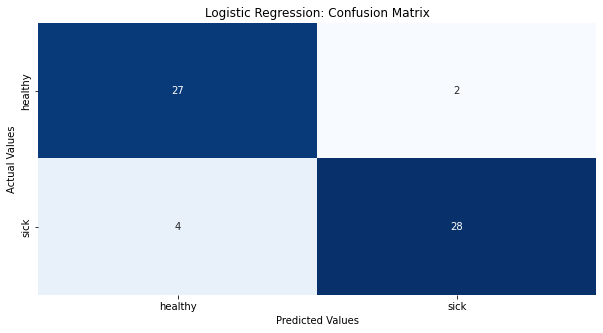

In [ ]:
labels_predicted = logisticRegression.predict(features_test)
plt.subplots(figsize=(10,5))

conf_mat = confusion_matrix(labels_test, labels_predicted)
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=['healthy', 'sick'], yticklabels=['healthy', 'sick'])
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.title('Logistic Regression: Confusion Matrix')

In [ ]:
labels_predicted = logisticRegression.predict(features_test)
print(classification_report(labels_test, labels_predicted, target_names = ['healthy', 'sick']))

              precision    recall  f1-score   support

     healthy       0.87      0.93      0.90        29
        sick       0.93      0.88      0.90        32

    accuracy                           0.90        61
   macro avg       0.90      0.90      0.90        61
weighted avg       0.90      0.90      0.90        61



In [76]:
# Creating a function to report confusion metrics
def confusion_metrics (conf_matrix):
# save confusion matrix and slice into four pieces
    TP = conf_matrix[1][1]
    TN = conf_matrix[0][0]
    FP = conf_matrix[0][1]
    FN = conf_matrix[1][0]
    print('True Positives:', TP)
    print('True Negatives:', TN)
    print('False Positives:', FP)
    print('False Negatives:', FN)
    
    # calculate accuracy
    conf_accuracy = (float (TP+TN) / float(TP + TN + FP + FN))
    
    # calculate mis-classification
    conf_misclassification = 1- conf_accuracy
    
    # calculate the sensitivity
    conf_sensitivity = (TP / float(TP + FN))
    # calculate the specificity
    conf_specificity = (TN / float(TN + FP))
    
    # calculate precision
    conf_precision = (TN / float(TN + FP))
    # calculate f_1 score
    conf_f1 = 2 * ((conf_precision * conf_sensitivity) / (conf_precision + conf_sensitivity))
    print('-'*50)
    print(f'Accuracy: {round(conf_accuracy,2)}') 
    print(f'Mis-Classification: {round(conf_misclassification,2)}') 
    print(f'Sensitivity: {round(conf_sensitivity,2)}') 
    print(f'Specificity: {round(conf_specificity,2)}') 
    print(f'Precision: {round(conf_precision,2)}')
    print(f'f_1 Score: {round(conf_f1,2)}')

### Naive Bayes

In [80]:
nb = GaussianNB()
nb.fit(features_train, labels_train)
nb.score(features_test,labels_test)

score = round(nb.score(features_test,labels_test), 3) *100

print(f"Naive Bayes accuracy is {score}%")

y_pred=nb.predict(features_test)
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
print("Classification Report is:\n",classification_report(labels_test,y_pred))
arr = confusion_matrix(labels_test,y_pred)
TP = arr[1][1]
TN = arr[0][0]
FP = arr[0][1]
FN = arr[1][0]
print("Confusion Matrix:\n",confusion_matrix(labels_test,y_pred))
print("Training Score:\n",nb.score(features_train,labels_train)*100)
print("Mean Squared Error:\n",mean_squared_error(labels_test,y_pred))
print("R2 score is:\n",r2_score(labels_test,y_pred))

Naive Bayes accuracy is 86.9%
Classification Report is:
               precision    recall  f1-score   support

           0       0.84      0.90      0.87        29
           1       0.90      0.84      0.87        32

    accuracy                           0.87        61
   macro avg       0.87      0.87      0.87        61
weighted avg       0.87      0.87      0.87        61

Confusion Matrix:
 [[26  3]
 [ 5 27]]
Training Score:
 84.29752066115702
Mean Squared Error:
 0.13114754098360656
R2 score is:
 0.47413793103448276


In [81]:
print('True Positives:', TP)
print('True Negatives:', TN)
print('False Positives:', FP)
print('False Negatives:', FN)
confaccuracy = (float (TP+TN) / float(TP + TN + FP + FN))
confmisclassification = 1- confaccuracy
confsensitivity = (TP / float(TP + FN))
confprecision = (TN / float(TN + FP))
conff1 = 2 * ((confprecision * confsensitivity) / (confprecision + confsensitivity))
print('-'*50)
print(f'Accuracy: {round(confaccuracy,2)}') 
print(f'Mis-Classification: {round(confmisclassification,2)}') 
print(f'Sensitivity: {round(confsensitivity,2)}') 
print(f'Precision: {round(confprecision,2)}')
print(f'f_1 Score: {round(conff1,2)}')

True Positives: 27
True Negatives: 26
False Positives: 3
False Negatives: 5
--------------------------------------------------
Accuracy: 0.87
Mis-Classification: 0.13
Sensitivity: 0.84
Precision: 0.9
f_1 Score: 0.87


Text(0.5, 1.0, 'Naive Bayes: Confusion Matrix')

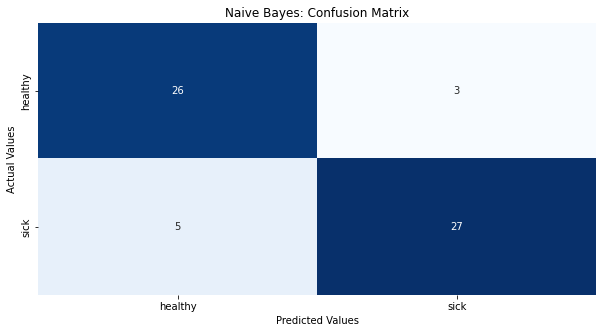

In [78]:
labels_predicted = nb.predict(features_test)
plt.subplots(figsize=(10,5))

conf_mat = confusion_matrix(labels_test, labels_predicted)
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=['healthy', 'sick'], yticklabels=['healthy', 'sick'])
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.title('Naive Bayes: Confusion Matrix')